<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/6.%201Q%20DD%20Dephasing%20Optimization%20(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [2]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 10.1 MB/s eta 0:00:00


In [3]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit, minimize

# CP CPMG UDD XY4 XY8 XY16 Sequence

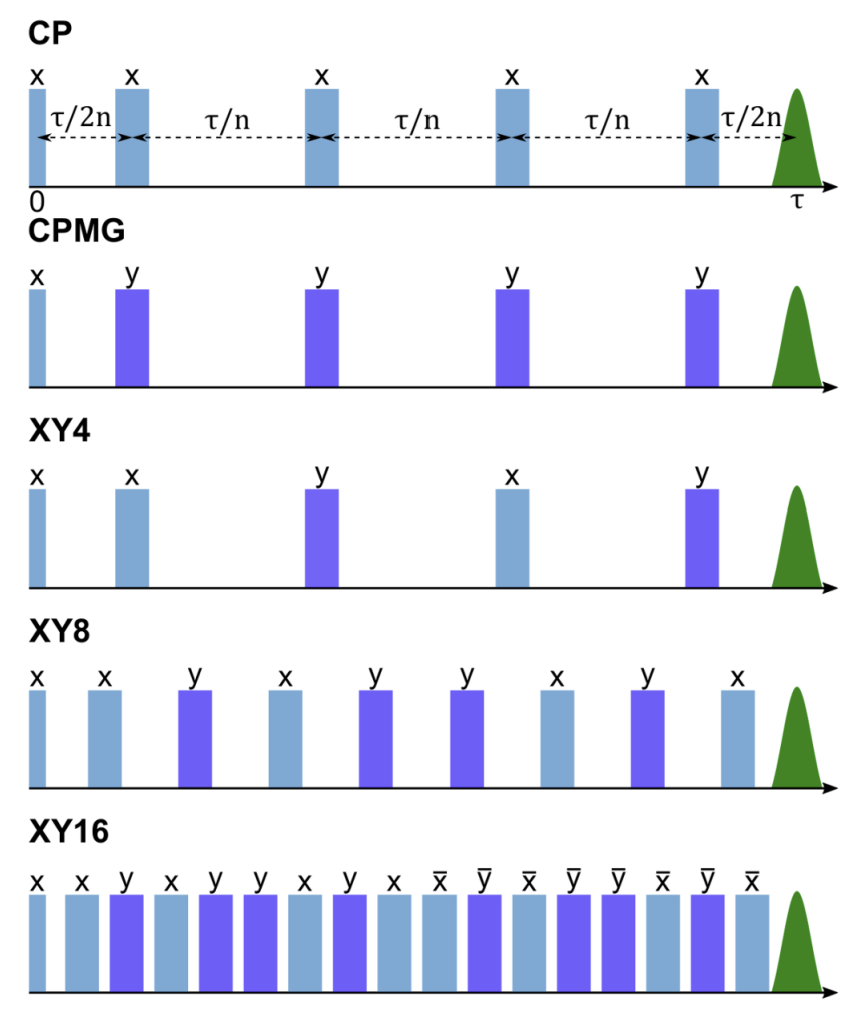

In [4]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_CP(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Optimized Case 1)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list
# only N=4 case

def Pulse_Timing_1(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = [0.2*T, 0.4*T, 0.6*T, 0.8*T]

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Optimized Case 1)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list
# only N=4 case

def Pulse_Timing_2(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = [0.232*T, 0.402*T, 0.598*T, 0.768*T]

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Optimized Case 1)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list
# only N=4 case

def Pulse_Timing_3(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = [0.1465*T, 0.24675*T, 0.75325*T, 0.8535*T]

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Optimized Case 1)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list
# only N=4 case

def Pulse_Timing_4(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = [0.15*T, 0.25*T, 0.75*T, 0.85*T]

    Seq = np.array(Seq_list)

    return Seq

In [5]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [6]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [7]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_CP(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [8]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_CP(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [9]:
# UDD (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [10]:
# Func1 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func1_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_1(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [11]:
# Func2 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func2_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_2(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [12]:
# Func3 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func3_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_3(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [13]:
# Func4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_4(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [14]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [15]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 1.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 1.0*np.pi)

    return pulse

In [16]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Optimized Sequence Determination

resonator drive : bare state

resonator drive : dressed state

## Setting

In [80]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.01        # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.05  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [81]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [82]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed, readout_number_bare, filter_number_bare]

H2 = sx_dressed

## Ramsey

$\omega_{qd} = 37.6381$

In [55]:
# Ramsey

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_0 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)
  coherence_list_0.append(avg)

coherence_list_0 = np.array(coherence_list_0)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.010793564858493629
dressed filter photon number : 0.005518360459765724
bare readout photon number : 0.022165414241792705
bare filter photon number : 0.002210428573680973


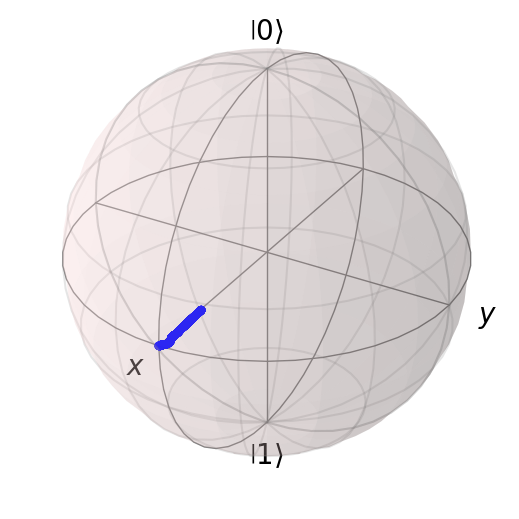

In [56]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

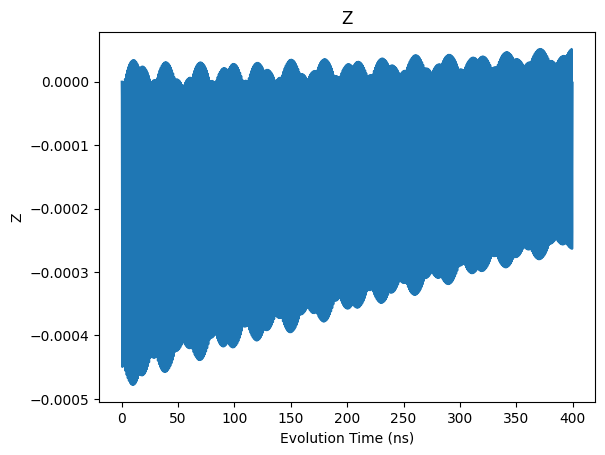

In [57]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6278247435737307


Text(0, 0.5, 'Coherence')

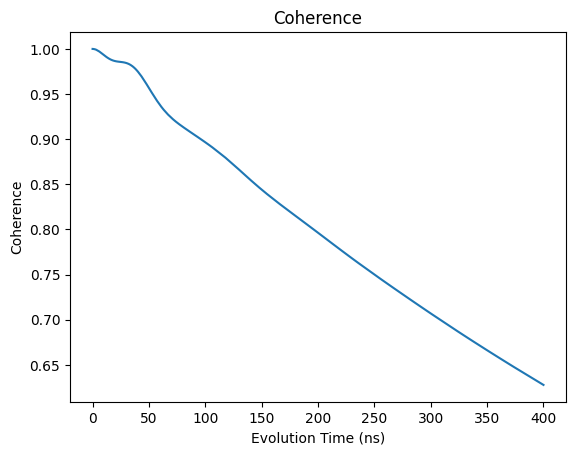

In [58]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## CPMG N=4

$\omega_{qd} = 37.6381$

In [84]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_1 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_1.append(avg)

coherence_list_1 = np.array(coherence_list_1)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.0161046714911046
dressed filter photon number : 0.007279059683811566
bare readout photon number : 0.029715302485630746
bare filter photon number : 0.0030706414455804656


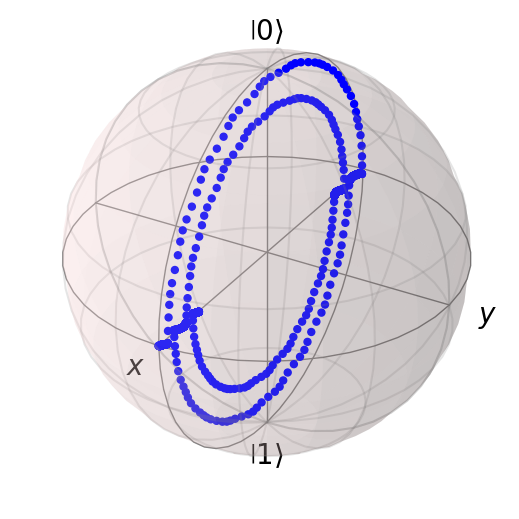

In [85]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

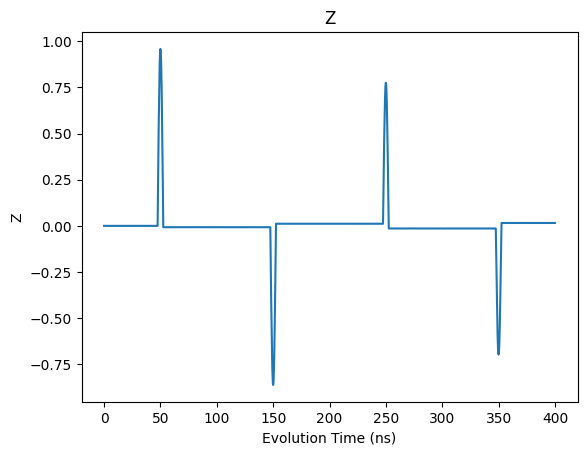

In [86]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6691244225760301


Text(0, 0.5, 'Coherence')

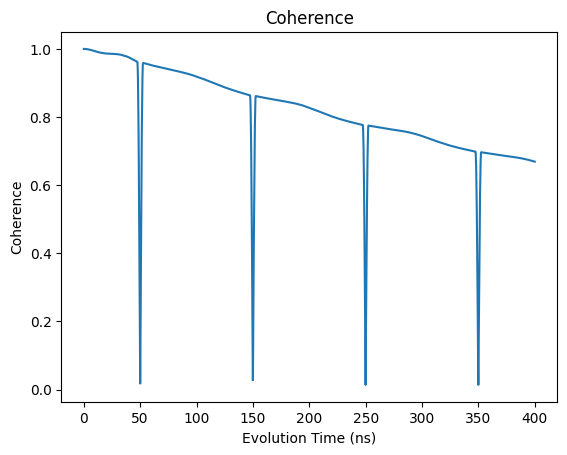

In [87]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## UDD N=4

$\omega_{qd} = 37.6381$

In [88]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_2 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, UDD_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_2.append(avg)

coherence_list_2 = np.array(coherence_list_2)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.015429931978538654
dressed filter photon number : 0.007095069315826115
bare readout photon number : 0.0291214911523734
bare filter photon number : 0.0030703484853297812


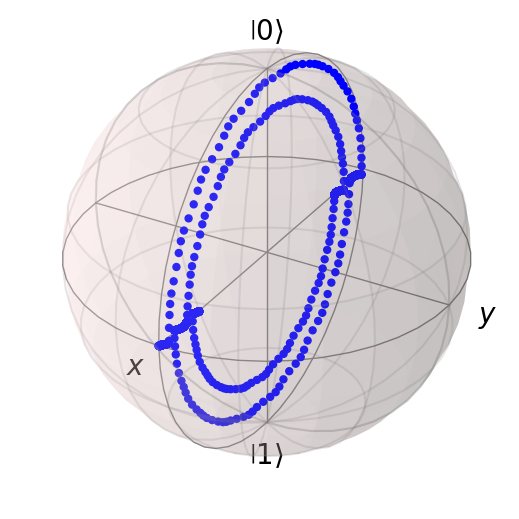

In [89]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

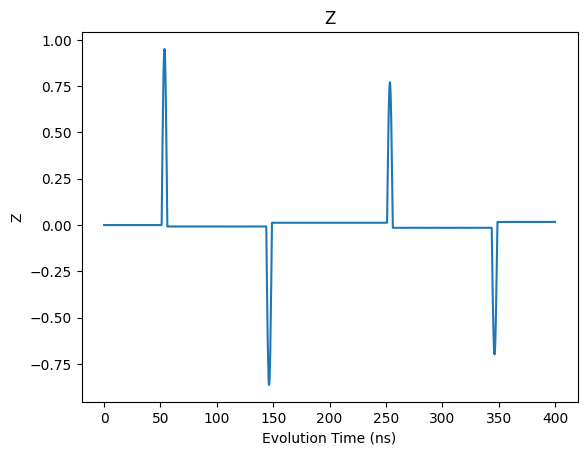

In [90]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6665028649738459


Text(0, 0.5, 'Coherence')

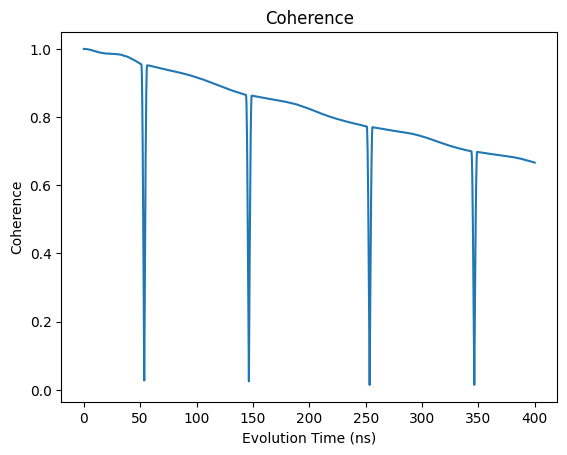

In [91]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 1

$\omega_{qd} = 37.6381$

In [92]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_3 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func1_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_3.append(avg)

coherence_list_3 = np.array(coherence_list_3)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.009723587521822672
dressed filter photon number : 0.005173423778202221
bare readout photon number : 0.021267554931490424
bare filter photon number : 0.0021760484682344207


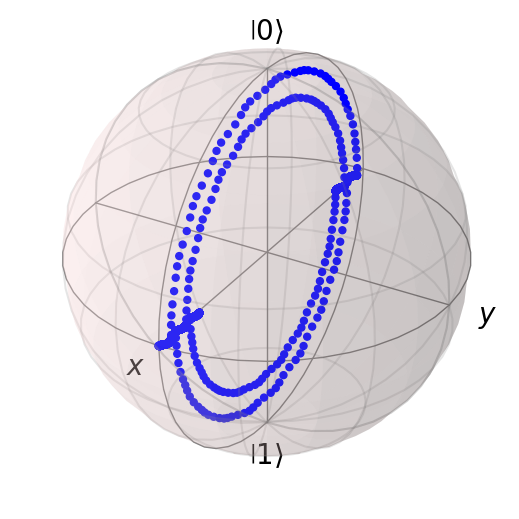

In [93]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

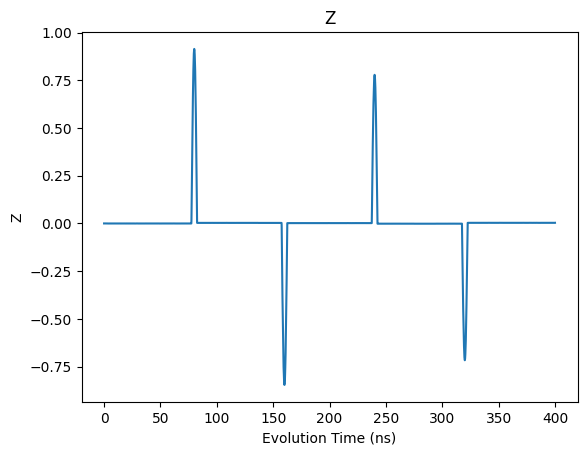

In [94]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6587651053968094


Text(0, 0.5, 'Coherence')

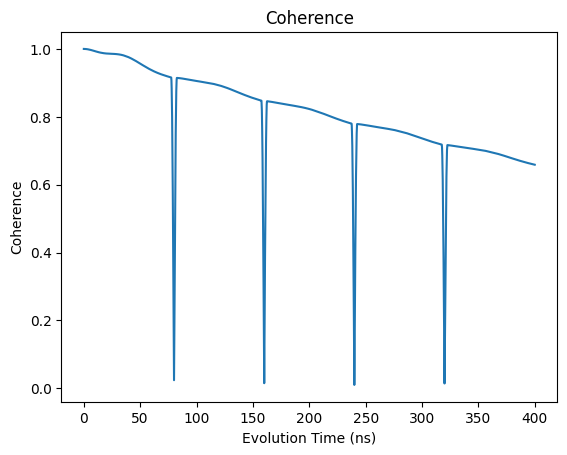

In [95]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 2

$\omega_{qd} = 37.6381$

In [96]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_4 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func2_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_4.append(avg)

coherence_list_4 = np.array(coherence_list_4)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.009417929211839909
dressed filter photon number : 0.0050343927859981185
bare readout photon number : 0.02043321917422235
bare filter photon number : 0.001984694205373426


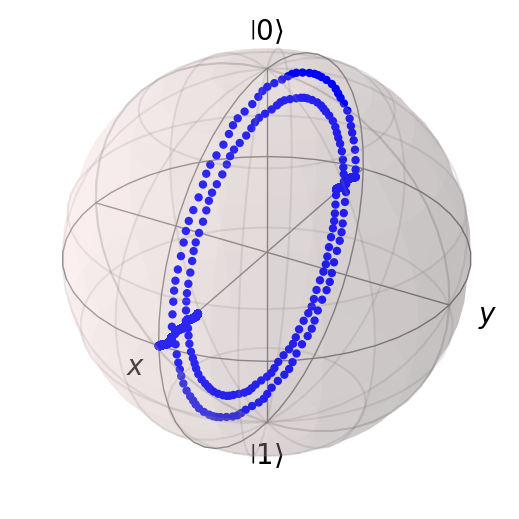

In [97]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

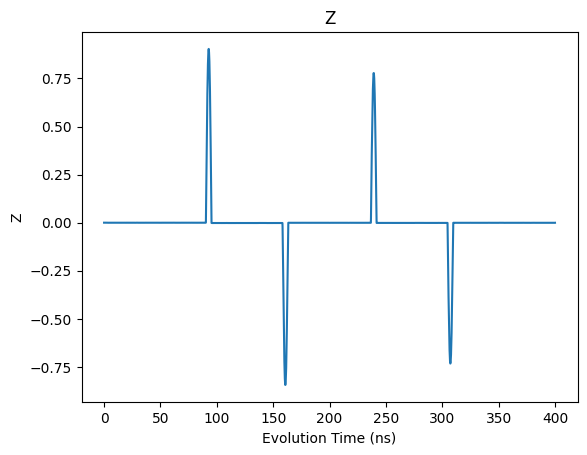

In [98]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6640590467574529


Text(0, 0.5, 'Coherence')

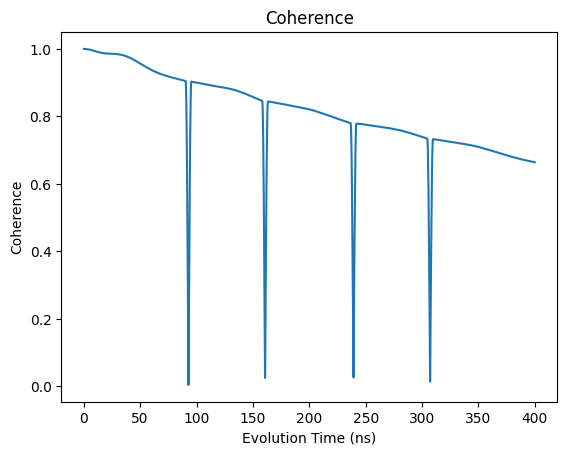

In [99]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 3

$\omega_{qd} = 37.6381$

In [100]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_5 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func3_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_5.append(avg)

coherence_list_5 = np.array(coherence_list_5)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.015593468776749666
dressed filter photon number : 0.007162667259238457
bare readout photon number : 0.029465689954889743
bare filter photon number : 0.003127348643582414


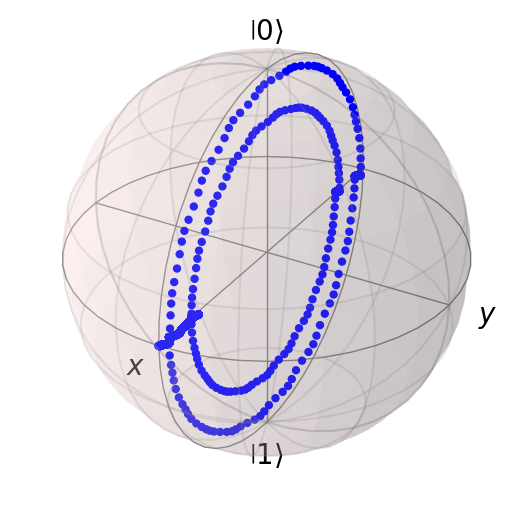

In [101]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

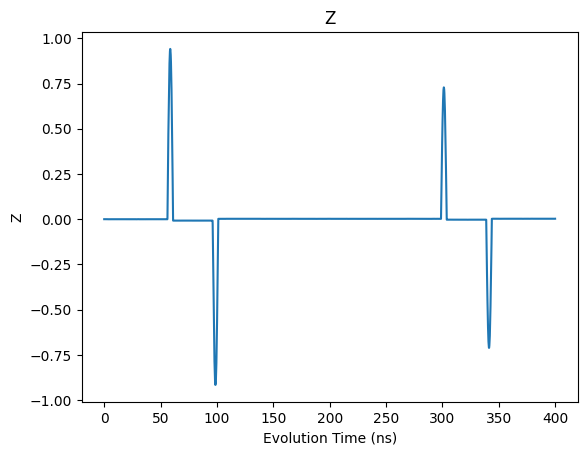

In [102]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6724148947853397


Text(0, 0.5, 'Coherence')

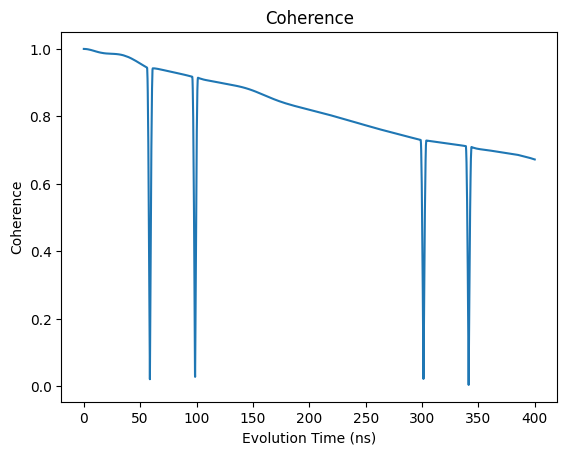

In [103]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 4

$\omega_{qd} = 37.6381$

In [104]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_6 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func4_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_6.append(avg)

coherence_list_6 = np.array(coherence_list_6)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.015280665482782766
dressed filter photon number : 0.007066232903640257
bare readout photon number : 0.02914929385812438
bare filter photon number : 0.0031075754875020626


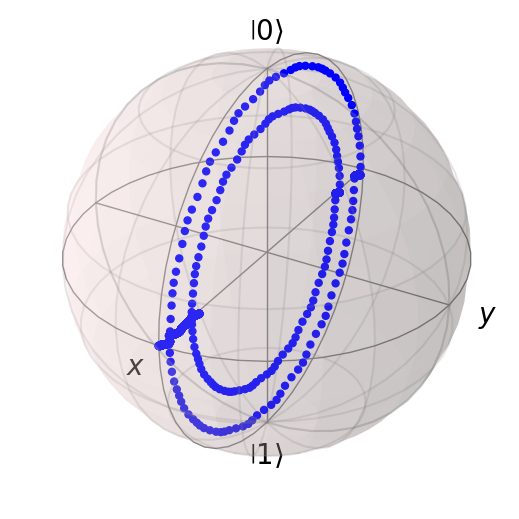

In [105]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

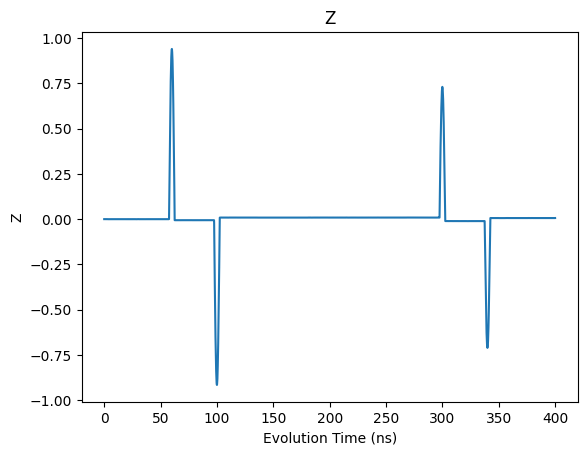

In [106]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6694853818590567


Text(0, 0.5, 'Coherence')

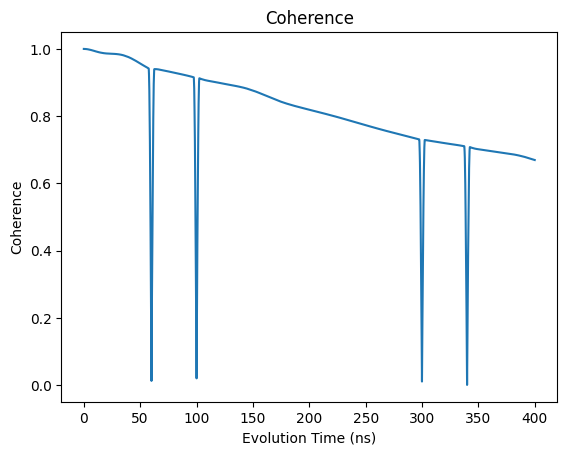

In [107]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Result

In [108]:
tau_list = np.array([50*(k+1) for k in range(8)])

Text(0, 0.5, 'Coherence')

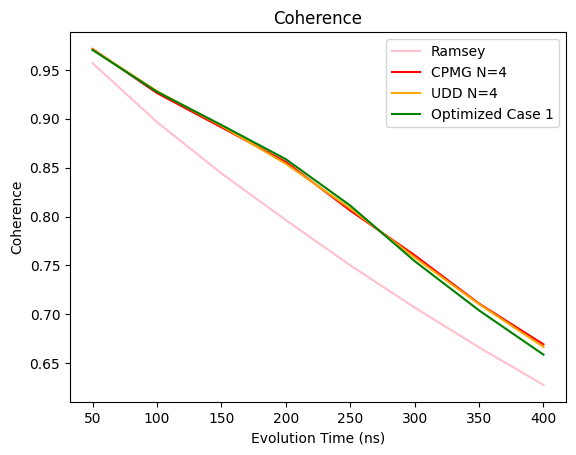

In [114]:
# Plot Results

plt.plot(tau_list, coherence_list_0, label = 'Ramsey', color='pink')
plt.plot(tau_list, coherence_list_1, label = 'CPMG N=4', color='red')
plt.plot(tau_list, coherence_list_2, label = 'UDD N=4', color='orange')
plt.plot(tau_list, coherence_list_3, label = 'Optimized Case 1', color='green')
#plt.plot(tau_list, coherence_list_4, label = 'Optimized Case 2', color='blue')
#plt.plot(tau_list, coherence_list_5, label = 'Optimized Case 3', color='purple')
#plt.plot(tau_list, coherence_list_6, label = 'Optimized Case 4', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

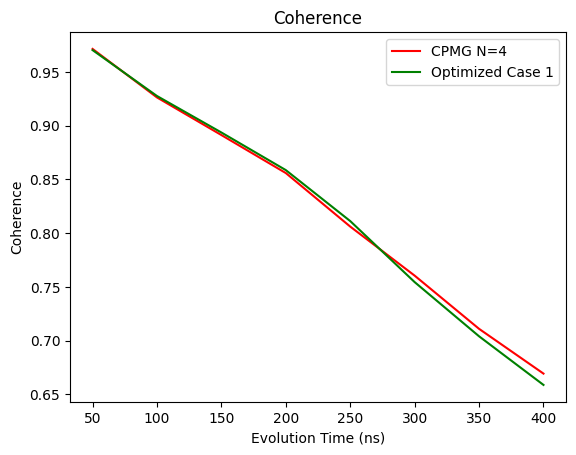

In [115]:
# Plot Results

#plt.plot(tau_list, coherence_list_0, label = 'Ramsey', color='pink')
plt.plot(tau_list, coherence_list_1, label = 'CPMG N=4', color='red')
#plt.plot(tau_list, coherence_list_2, label = 'UDD N=4', color='orange')
plt.plot(tau_list, coherence_list_3, label = 'Optimized Case 1', color='green')
#plt.plot(tau_list, coherence_list_4, label = 'Optimized Case 2', color='blue')
#plt.plot(tau_list, coherence_list_5, label = 'Optimized Case 3', color='purple')
#plt.plot(tau_list, coherence_list_6, label = 'Optimized Case 4', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

In [110]:
print(coherence_list_0)
print(coherence_list_1)
print(coherence_list_2)
print(coherence_list_3)
print(coherence_list_4)
print(coherence_list_5)
print(coherence_list_6)

[0.95670185 0.89657576 0.84415662 0.79637024 0.7500948  0.70698766
 0.66621434 0.62782474]
[0.97134495 0.92620523 0.89121273 0.85586273 0.80606934 0.76043857
 0.71094572 0.66930661]
[0.97092857 0.92815378 0.89269017 0.85390336 0.80821469 0.7581254
 0.71040996 0.66671347]
[0.97024494 0.92754678 0.89358202 0.85860884 0.81118967 0.75441742
 0.70400178 0.65877352]
[0.96820315 0.92838597 0.89673645 0.85584855 0.80428206 0.75136425
 0.70318526 0.66405923]
[0.9707651  0.92435778 0.87404209 0.83611175 0.79886943 0.75977803
 0.71372904 0.67241983]
[0.97093159 0.92498286 0.8745875  0.8369227  0.79951375 0.75742514
 0.71296538 0.66951303]


# Optimized Sequence Determination

resonator drive : bare state

resonator drive : bare state

## Setting

In [17]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.01        # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.05  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [18]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [19]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed, readout_number_bare, filter_number_bare]

H2 = sx_bare

## Ramsey

$\omega_{qd} = 37.6381$

In [119]:
# Ramsey

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_0 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)
  coherence_list_0.append(avg)

coherence_list_0 = np.array(coherence_list_0)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.010793564858493629
dressed filter photon number : 0.005518360459765724
bare readout photon number : 0.022165414241792705
bare filter photon number : 0.002210428573680973


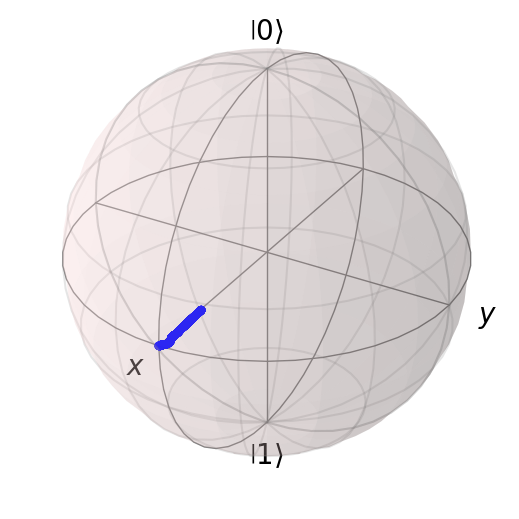

In [120]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

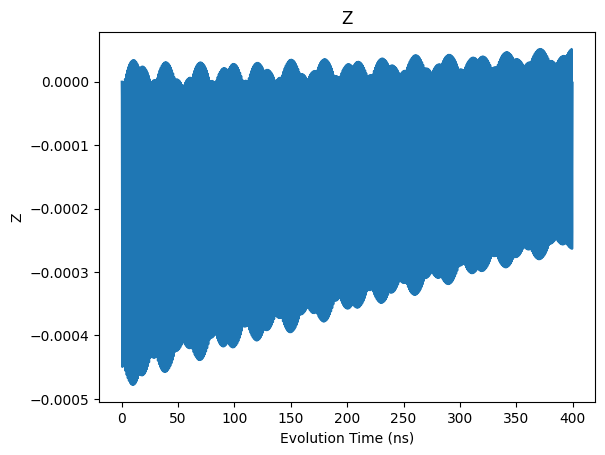

In [121]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6278247435737307


Text(0, 0.5, 'Coherence')

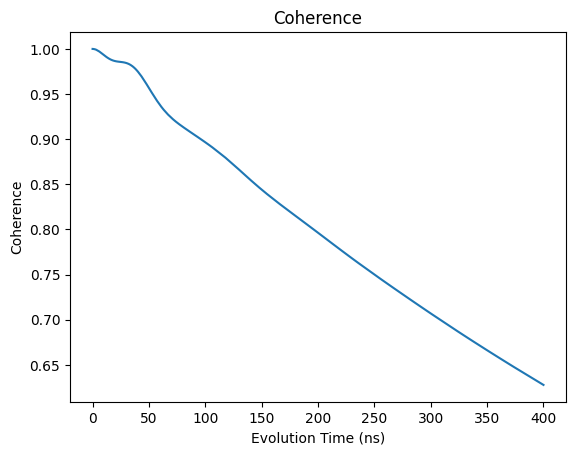

In [122]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## CPMG N=4

$\omega_{qd} = 37.6381$

In [123]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_1 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_1.append(avg)

coherence_list_1 = np.array(coherence_list_1)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.02247058751499887
dressed filter photon number : 0.009404969909634693
bare readout photon number : 0.038949079120740686
bare filter photon number : 0.005090712550608907


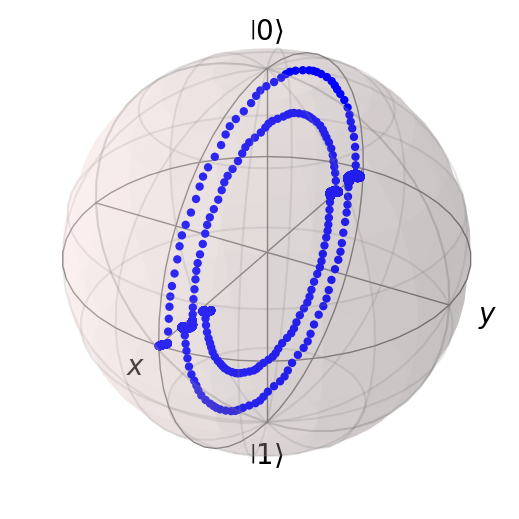

In [124]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

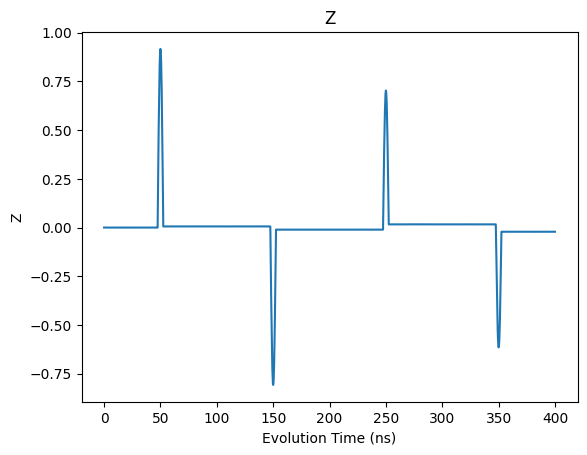

In [125]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.5768564015188935


Text(0, 0.5, 'Coherence')

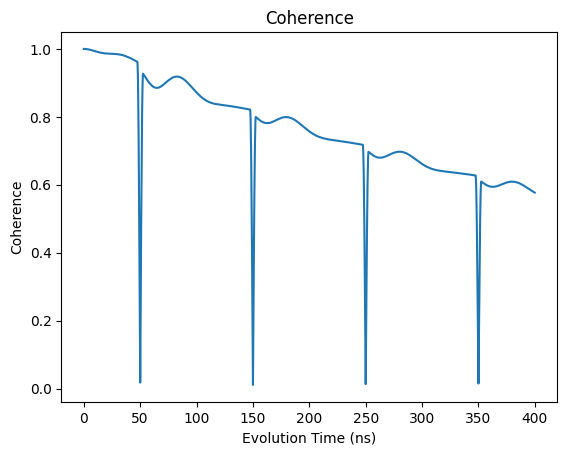

In [126]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## UDD N=4

$\omega_{qd} = 37.6381$

In [127]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_2 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, UDD_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_2.append(avg)

coherence_list_2 = np.array(coherence_list_2)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.01688489147639991
dressed filter photon number : 0.007598395481158469
bare readout photon number : 0.03156198250281107
bare filter photon number : 0.004080543809689691


In [133]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

In [ ]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 1

$\omega_{qd} = 37.6381$

In [20]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_3 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func1_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_3.append(avg)

coherence_list_3 = np.array(coherence_list_3)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.006074617521105301
dressed filter photon number : 0.003763483522930921
bare readout photon number : 0.015573949144804937
bare filter photon number : 0.001444969483239013


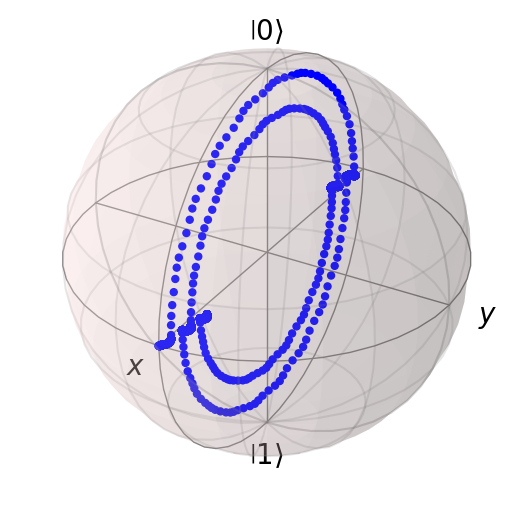

In [21]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

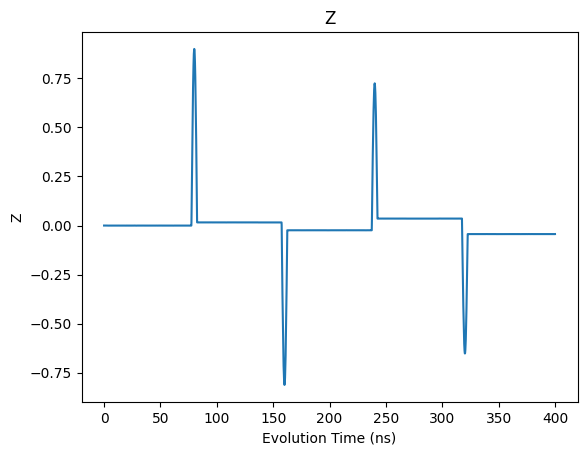

In [22]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.587296453036516


Text(0, 0.5, 'Coherence')

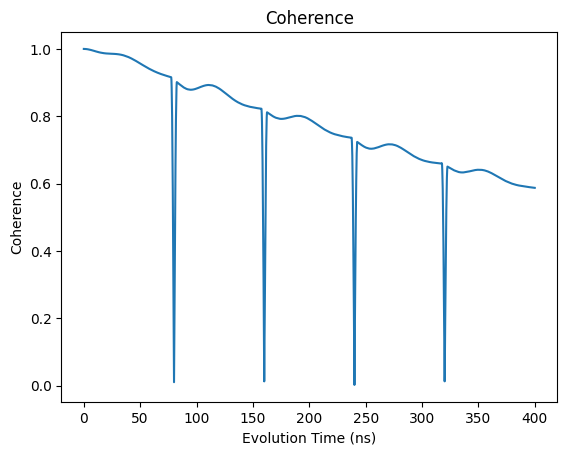

In [23]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 2

$\omega_{qd} = 37.6381$

In [ ]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_4 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func2_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_4.append(avg)

coherence_list_4 = np.array(coherence_list_4)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.009417929211839909
dressed filter photon number : 0.0050343927859981185
bare readout photon number : 0.02043321917422235
bare filter photon number : 0.001984694205373426


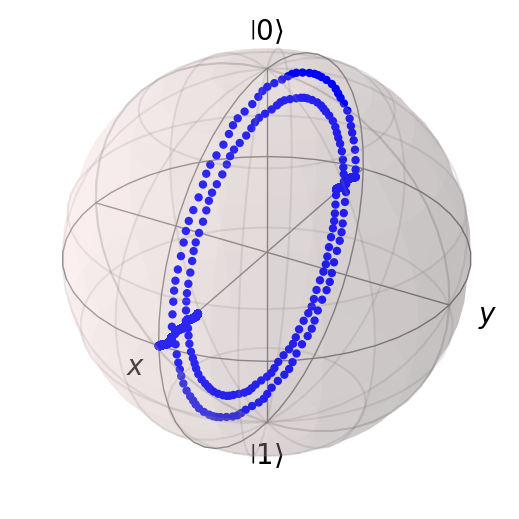

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

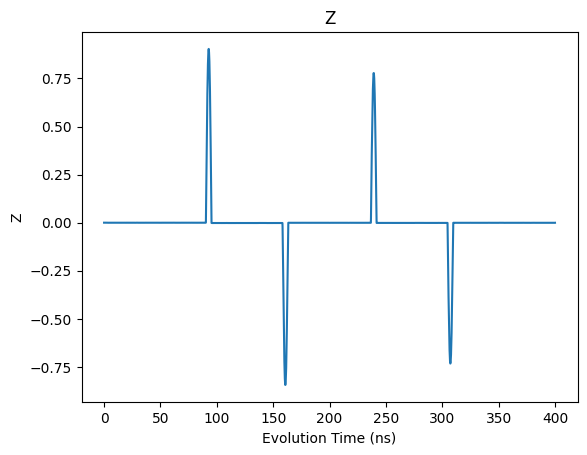

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6640590467574529


Text(0, 0.5, 'Coherence')

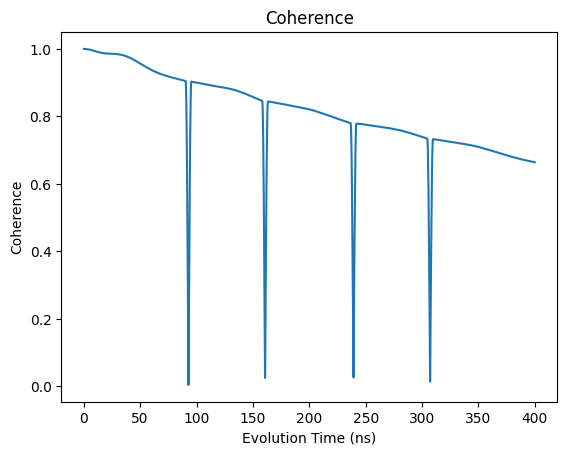

In [ ]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 3

$\omega_{qd} = 37.6381$

In [ ]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_5 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func3_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_5.append(avg)

coherence_list_5 = np.array(coherence_list_5)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.015593468776749666
dressed filter photon number : 0.007162667259238457
bare readout photon number : 0.029465689954889743
bare filter photon number : 0.003127348643582414


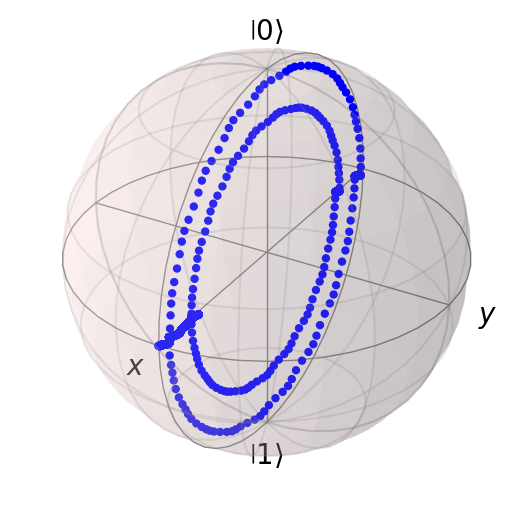

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

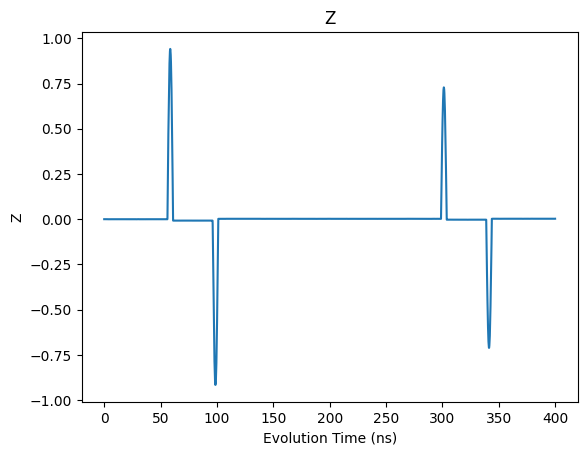

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.6724148947853397


Text(0, 0.5, 'Coherence')

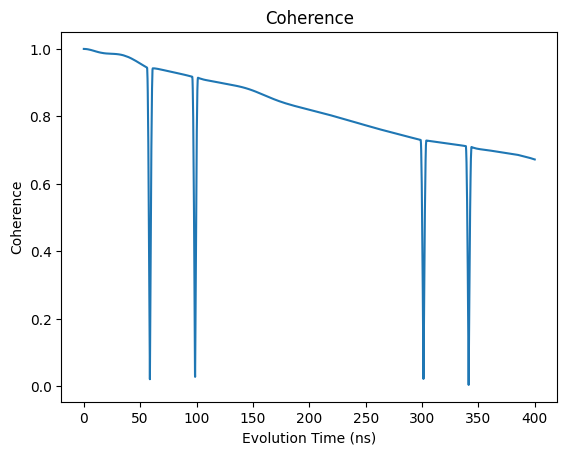

In [ ]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Optimized Sequence 4

$\omega_{qd} = 37.6381$

In [27]:
# Ramsey

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

coherence_list_6 = []

# iterate for evolution time 50ns ~ 750ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 50*(k+1), 500*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Func4_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 50*(k+1), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2 + result.expect[2][-1]**2)

  coherence_list_6.append(avg)

coherence_list_6 = np.array(coherence_list_6)


x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

0
1
2
3
4
5
6
7
dressed readout photon number : 0.015439732652747715
dressed filter photon number : 0.006914024953043286
bare readout photon number : 0.02930766933362501
bare filter photon number : 0.004170412526684059


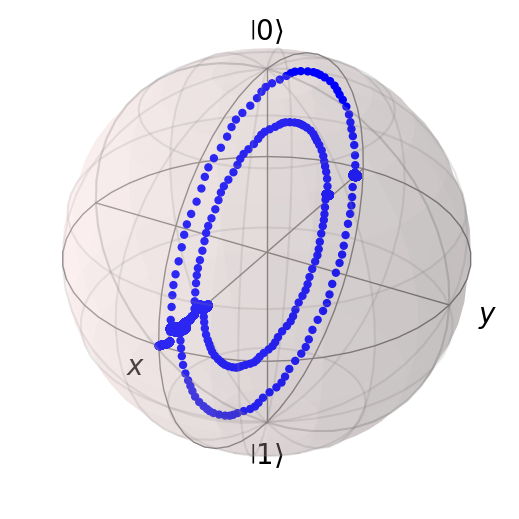

In [28]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

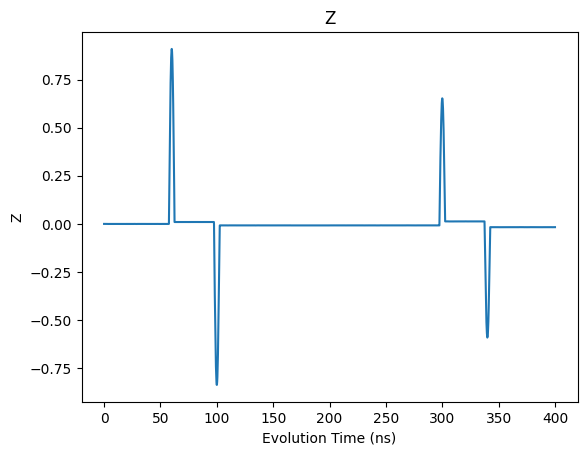

In [29]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.5447044763425694


Text(0, 0.5, 'Coherence')

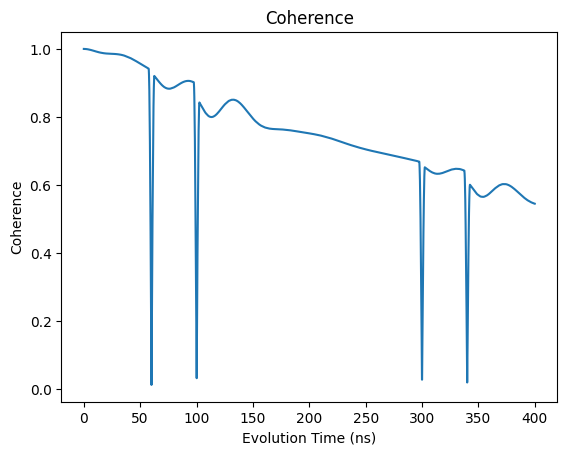

In [30]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Result

In [31]:
tau_list = np.array([50*(k+1) for k in range(8)])

Text(0, 0.5, 'Coherence')

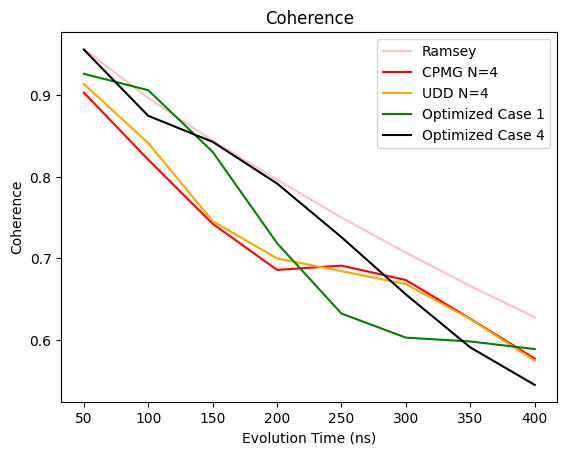

In [34]:
# Plot Results

plt.plot(tau_list, coherence_list_0, label = 'Ramsey', color='pink')
plt.plot(tau_list, coherence_list_1, label = 'CPMG N=4', color='red')
plt.plot(tau_list, coherence_list_2, label = 'UDD N=4', color='orange')
plt.plot(tau_list, coherence_list_3, label = 'Optimized Case 1', color='green')
#plt.plot(tau_list, coherence_list_4, label = 'Optimized Case 2', color='blue')
#plt.plot(tau_list, coherence_list_5, label = 'Optimized Case 3', color='purple')
plt.plot(tau_list, coherence_list_6, label = 'Optimized Case 4', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

In [32]:
coherence_list_0 = np.array([0.95670185, 0.89657576, 0.84415662, 0.79637024, 0.7500948,  0.70698766,
 0.66621434, 0.62782474])
coherence_list_1 = np.array([0.90319558, 0.82097981, 0.7424664,  0.6859195,  0.69113955, 0.67351945,
 0.62598599, 0.57725852])
coherence_list_2 = np.array([0.9136165,  0.84148446, 0.74564737, 0.70004455, 0.68440497, 0.66849848,
 0.62562868, 0.5748222 ])
coherence_list_3 = np.array([0.92623466, 0.90612263, 0.83054511, 0.71864704, 0.6324122,  0.60290154,
 0.59823036, 0.58889641])

In [33]:
print(coherence_list_0)
print(coherence_list_1)
print(coherence_list_2)
print(coherence_list_3)
print(coherence_list_6)

[0.95670185 0.89657576 0.84415662 0.79637024 0.7500948  0.70698766
 0.66621434 0.62782474]
[0.90319558 0.82097981 0.7424664  0.6859195  0.69113955 0.67351945
 0.62598599 0.57725852]
[0.9136165  0.84148446 0.74564737 0.70004455 0.68440497 0.66849848
 0.62562868 0.5748222 ]
[0.92623466 0.90612263 0.83054511 0.71864704 0.6324122  0.60290154
 0.59823036 0.58889641]
[0.95590042 0.8747181  0.8428686  0.79176554 0.72600433 0.65585654
 0.59093914 0.54496801]
